In [2]:

import simsz.utils as utils
import make_sz_cluster
import simsz.read_yaml as read_yaml
import simsz.load_vars as load_vars
from simsz import simtools, make_dm_halo
from colossus.halo import mass_adv

import time
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import h5py
from pixell import enmap, powspec, enplot
import camb
import healpy as hp

from astropy.constants import M_sun
from astropy.constants import G, sigma_T, m_e, c, h, k_B
from astropy import units as u

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
(survey,survey_freq,beam_size,noise_level,image_size,pixel_scale,cosmo,sigma8,ns)=load_vars.load_vars('./simsz/Settings/inputdata.yaml').make_dict_and_flatLCDM() #Make a dictionary and cosmology from the .yaml

AttributeError: module 'make_sz_cluster' has no attribute 'GenerateCluster'

In [6]:
fSZ_148=simtools.f_sz(148,cosmo.Tcmb0) #get f_SZ for observation frequency of 30 GHz


In [8]:
map_148 = hp.read_map('Data/local/148_tsz_healpix.fits.txt')

In [9]:
cols = ['redshift', 'ra', 'dec', 'comoving_pos_x', 'comoving_pos_y', 'comoving_pos_z', 'proper_peculiar_v_x', 'proper_peculiar_v_y', 'proper_peculiar_v_z',
        'Mfof', 'Mvir', 'Mgas_vir', 'Rvir', 'TSZ_Rvir', 'KSZ_Rvir', 'SZ_148_vir', 'SZ_219_vir', 'SZ_277_vir', 'SZ_30_vir', 'SZ_90_vir', 'SZ_350_vir',
       'M200', 'Mgas_200', 'R200', 'TSZ_R200', 'KSZ_R200', 'SZ_148_R200', 'SZ_219_R200', 'SZ_277_R200', 'SZ_30_R200', 'SZ_90_R200', 'SZ_350_R200',
               'M500', 'Mgas_500', 'R500', 'TSZ_R500', 'KSZ_R500', 'SZ_148_R500', 'SZ_219_R500', 'SZ_277_R500', 'SZ_30_R500', 'SZ_90_R500', 'SZ_350_R500',
        'Mstar', 'central gas density', 'central temp', 'central pressure', 'central potential'
       ]
df = pd.read_csv('./Data/local/halo_sz.ascii', sep='\s+', names=cols)

In [10]:
mass_min, mass_max = (1.1e14, 1.7e14)
z_min, z_max = (0.5, 0.7)
df_mass = df[(df['M200'] >= mass_min) & (df['M200'] <= mass_max)]
df_bin = df_mass[(df_mass['redshift'] >= z_min) & (df_mass['redshift'] <= z_max)]
df_bin

,redshift,ra,dec,comoving_pos_x,comoving_pos_y,comoving_pos_z,proper_peculiar_v_x,proper_peculiar_v_y,proper_peculiar_v_z,Mfof,...,SZ_219_R500,SZ_277_R500,SZ_30_R500,SZ_90_R500,SZ_350_R500,Mstar,central gas density,central temp,central pressure,central potential
185469,0.5014,31.17725,60.863590,788.0667,476.8425,1652.4210,158.808900,246.117800,169.01710,1.576271e+14,...,-5.646132e-06,0.000013,-0.000047,-0.000039,0.000039,3.368958e+12,7.604000e+13,2.551557,3.301000e+13,-2.14731
185482,0.5014,65.50480,56.936300,427.7884,938.9042,1584.9220,-16.275850,422.631700,-573.46800,3.190987e+14,...,8.082975e-06,0.000043,-0.000067,-0.000053,0.000090,4.514349e+12,6.991000e+13,3.452085,4.106000e+13,-2.96500
185492,0.5019,52.06753,60.297470,576.5526,739.7491,1644.1310,637.596600,12.974540,701.15800,1.706986e+14,...,-2.027308e-05,0.000005,-0.000075,-0.000065,0.000038,3.493131e+12,1.039000e+14,2.855089,5.047000e+13,-2.49678
185538,0.5007,74.04274,22.440090,480.0184,1678.7480,721.0902,-137.576700,271.492000,331.57050,1.816556e+14,...,-7.592684e-06,0.000014,-0.000055,-0.000046,0.000043,4.018410e+12,4.410000e+13,2.380371,1.786000e+13,-1.95030
185570,0.5014,44.25753,17.439920,1292.3660,1259.2990,566.8618,312.436000,261.797300,-538.63100,1.626250e+14,...,-5.597754e-06,0.000018,-0.000058,-0.000048,0.000051,3.369115e+12,1.406000e+14,2.912476,6.967000e+13,-2.59776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386138,0.6983,74.48936,2.579956,670.1461,2414.7270,112.9180,55.502490,192.058400,-333.61210,1.327335e+14,...,-2.430282e-06,0.000010,-0.000029,-0.000024,0.000026,2.819655e+12,1.241000e+14,2.600647,5.491000e+13,-2.23100
386166,0.6968,49.93632,70.277170,543.9407,646.7820,2357.3200,-440.640900,9.780079,181.04570,2.052996e+14,...,-1.069073e-06,0.000015,-0.000036,-0.000030,0.000037,3.303445e+12,1.513000e+14,3.285332,8.457000e+13,-2.82942
386186,0.6994,61.59157,53.379160,712.9762,1318.1580,2016.3670,89.607170,-254.025700,220.38040,1.255250e+14,...,-7.723829e-07,0.000010,-0.000024,-0.000020,0.000025,2.812979e+12,1.510000e+14,2.550733,6.553000e+13,-2.23344
386192,0.6983,46.16276,59.741000,875.6694,911.9525,2167.1490,-174.479000,310.976400,-98.09206,1.418644e+14,...,6.197620e-07,0.000015,-0.000030,-0.000024,0.000034,2.887536e+12,2.351000e+14,3.110066,1.244000e+14,-2.72646


In [11]:
ra = np.array(df_bin['ra']) #celectrial long
dec = np.array(df_bin['dec']) # celestial lat
z_arr = np.array(df_bin['redshift'])
M200_arr = np.array(df_bin['M200'])
R200_arr = np.array(df_bin['R200'])

In [12]:
def make_difference_map(ra, dec, z, M200, R200, map_to_cut):
    conversion_148 = 1.072480e9
    beam_size_fwhp = 1.25
    pix_size=0.2
    
    map_cut_148=hp.gnomview(map_to_cut,rot=[ra,dec],reso=pix_size,return_projected_map=True, xsize=41, ysize=41, no_plot=True)
    dT_cut_148 = -map_cut_148/conversion_148 * 2725000 * u.uK
    dT_cut_conv = simtools.convolve_map_with_gaussian_beam(0.5, beam_size_fwhp, dT_cut_148)
    
    P200 = szcluster.P200_Battaglia2012(cosmo,z,M200,R200) #P200 from Battaglia et al. 2012
    P0=szcluster.param_Battaglia2012(18.1,0.154,-0.758,M200,z) #Parameter computation from Table 1 Battaglia et al. 2012
    xc=szcluster.param_Battaglia2012(0.497,-0.00865,0.731,M200,z)
    beta=szcluster.param_Battaglia2012(4.35,0.0393,0.415,M200,z)
    y_map = szcluster.make_y_submap(szcluster.Pth_Battaglia2012, z, cosmo, pix_size*20, pix_size, R200_mpc=R200, gamma=-0.3,alpha=1.0,beta=beta,xc=xc,P0=P0, P200_kevcm3=P200)
    
    dT_map_148 = (y_map * cosmo.Tcmb0 * -fSZ_148).to(u.uK)
    dT_map_conv = simtools.convolve_map_with_gaussian_beam(0.5, beam_size_fwhp, dT_map_148)
    
    diff_map = dT_cut_148 - dT_map_148
    #percent_map = diff_map / dT_map_148
    percent_map_2 = diff_map / dT_cut_conv
    
    return diff_map, percent_map_2, percent_map_2

In [20]:
added_map = np.zeros((41,41))
add_per_map = np.zeros((41,41))
num_loops = 100 # max of 36930
for ind in range(num_loops):
    z=z_arr[ind]
    M200=M200_arr[ind]
    R200=R200_arr[ind] / cosmo.scale_factor(z) # Go from Mpc proper to Mpc comoving
    diff_map, percent_map, _ = make_difference_map(ra[ind], dec[ind], z, M200, R200, map_148)
    added_map = added_map + diff_map
    add_per_map = add_per_map + _

In [13]:
def do_loops(mass_min, mass_max, z_min, z_max, num_loops):
    df_mass = df[(df['M200'] >= mass_min) & (df['M200'] <= mass_max)]
    df_bin = df_mass[(df_mass['redshift'] >= z_min) & (df_mass['redshift'] <= z_max)]
    ra = np.array(df_bin['ra']) #celectrial long
    dec = np.array(df_bin['dec']) # celestial lat
    z_arr = np.array(df_bin['redshift'])
    M200_arr = np.array(df_bin['M200'])
    R200_arr = np.array(df_bin['R200'])
    added_map = np.zeros((41,41))
    #add_per_map = np.zeros((41,41))
    add_per_map_seghal = np.zeros((41,41))
    #print(f'starting {num_loops} loops')
    for ind in range(num_loops):
        z=z_arr[ind]
        M200=M200_arr[ind]
        R200=R200_arr[ind] / cosmo.scale_factor(z) # Go from Mpc proper to Mpc comoving
        diff_map, percent_map, seghal_per_map = make_difference_map(ra[ind], dec[ind], z, M200, R200, map_148)
        added_map = added_map + diff_map
        #add_per_map = add_per_map + percent_map
        add_per_map_seghal = add_per_map_seghal + seghal_per_map
    
    if isinstance(added_map, u.Quantity):
        added_map = added_map.value
        add_per_map_seghal = add_per_map_seghal.value
    
    np.save(f'Diff_map_conv: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', added_map)
    #np.save(f'Percent_map: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', add_per_map.value)
    np.save(f'Percent_map_2_conv: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', add_per_map_seghal)
    
    print(f'Done with {mass_min}-{mass_max};{z_min}-{z_max}')
    return added_map, add_per_map_seghal, add_per_map_seghal

In [56]:
added_map, add_per_map, add_per_map_seghal = do_loops(1.1e14, 1.7e14, 0, 0.3, 1000)

Done with 110000000000000.0-170000000000000.0;0-0.3


In [57]:

added_map, add_per_map, add_per_map_seghal = do_loops(1.1e14, 1.7e14, 0.3, 0.5, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(1.1e14, 1.7e14, 0.5, 0.7, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.73e14, 1.1e14, 0, 0.3, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.73e14, 1.1e14, 0.3, 0.5, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.73e14, 1.1e14, 0.5, 0.7, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.47e14, 0.73e14, 0, 0.3, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.47e14, 0.73e14, 0.3, 0.5, 1000)
added_map, add_per_map, add_per_map_seghal = do_loops(0.47e14, 0.73e14, 0.5, 0.7, 1000)

Done with 110000000000000.0-170000000000000.0;0.3-0.5
Done with 110000000000000.0-170000000000000.0;0.5-0.7
Done with 73000000000000.0-110000000000000.0;0-0.3
Done with 73000000000000.0-110000000000000.0;0.3-0.5
Done with 73000000000000.0-110000000000000.0;0.5-0.7
Done with 47000000000000.0-73000000000000.0;0-0.3
Done with 47000000000000.0-73000000000000.0;0.3-0.5
Done with 47000000000000.0-73000000000000.0;0.5-0.7


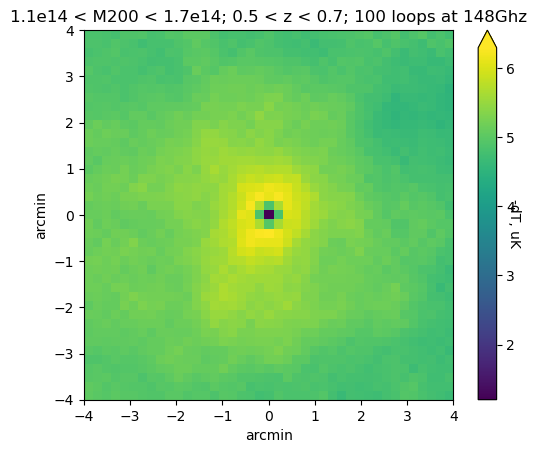

In [30]:
width = 4
im = plt.imshow(added_map/1000)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title(f'{mass_min/1e14}e14 < M200 < {mass_max/1e14}e14; {z_min} < z < {z_max}; {num_loops} loops at 148Ghz')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('-dT, uK', rotation=270)

Central pixel =  0.7596153009811085 %


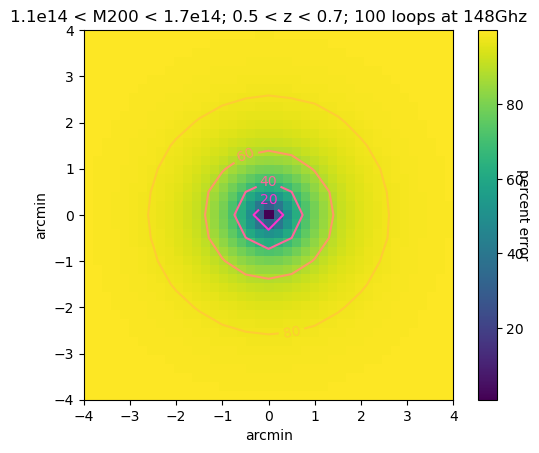

In [31]:
width = 4
fig, ax = plt.subplots()
centre = add_per_map[20,20]
#add_per_map[20,20] = 0
im = ax.imshow(add_per_map/10)
cbar = plt.colorbar(im)
CS = ax.contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), add_per_map/10, levels=5, cmap="spring")
im.set_extent([-width,width,-width,width])
plt.clabel(CS)
plt.title(f'{mass_min/1e14}e14 < M200 < {mass_max/1e14}e14; {z_min} < z < {z_max}; {num_loops} loops at 148Ghz')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('percent error', rotation=270)
print("Central pixel = ", add_per_map[20,20]/10, "%")

In [279]:
ind = 0
z=z_arr[ind]
M200=M200_arr[ind]
R200=R200_arr[ind] / cosmo.scale_factor(z) # Go from Mpc proper to Mpc comoving
diff_map, percent_map, _ = make_difference_map(ra[ind], dec[ind], z, M200, R200, map_148)

-160.859134605184


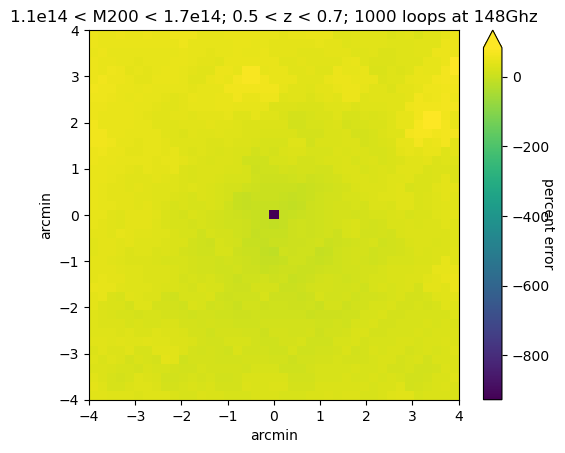

In [281]:
width = 4
im = plt.imshow(percent_map*100)
cbar = plt.colorbar(im, extend="max")
im.set_extent([-width,width,-width,width])
plt.title(f'{mass_min/1e14}e14 < M200 < {mass_max/1e14}e14; {z_min} < z < {z_max}; {num_loops} loops at 148Ghz')
plt.ylabel('arcmin')
plt.xlabel('arcmin')
cbar.set_label('percent error', rotation=270)
print(add_per_map[20,20])

In [247]:
np.save(f'Diff_map: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', added_map.value)
np.save(f'Percent_map: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', add_per_map.value)
np.save(f'Percent_map_2: {mass_min/1e14}-{mass_max/1e14}e14;{z_min}-{z_max}.npy', add_per_map_seghal.value)

In [201]:
axes[0,0].titlesize

AttributeError: 'Axes' object has no attribute 'titlesize'

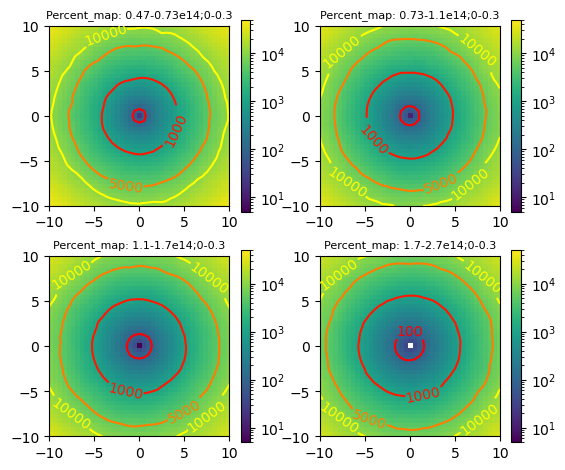

In [210]:
#make a grid
fig, axes = plt.subplots(2, 2)
extent= [-10,10,-10,10]

vmin, vmax = (5, 50000)
im1 = axes[0,0].imshow(map_1, norm=LogNorm(vmin=vmin, vmax=vmax)) 
axes[0,0].set_title(str_1, fontsize=8)
CS1 = axes[0,0].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_1, levels=[100,1000,5000,10000], cmap="autumn")
im1.set_extent(extent)
plt.clabel(CS1)

im2 = axes[0,1].imshow(map_2, norm=LogNorm(vmin=vmin, vmax=vmax))
axes[0,1].set_title(str_2, fontsize=8)
CS2 = axes[0,1].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_2, levels=[100,1000,5000,10000], cmap="autumn")
im2.set_extent(extent)
plt.clabel(CS2)

im3 = axes[1,0].imshow(map_3, norm=LogNorm(vmin=vmin, vmax=vmax))
axes[1,0].set_title(str_3, fontsize=8)
CS3 = axes[1,0].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_3, levels=[100,1000,5000,10000], cmap="autumn")
im3.set_extent(extent)
plt.clabel(CS3)

im4 = axes[1,1].imshow(map_4, norm=LogNorm(vmin=vmin, vmax=vmax))
axes[1,1].set_title(str_4, fontsize=8)
CS4 = axes[1,1].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_4, levels=[100,1000,5000,10000], cmap="autumn")
im4.set_extent(extent)
plt.clabel(CS4)

plt.subplots_adjust(bottom=0)
plt.colorbar(im1)
cbar = plt.colorbar(im2)
cbar = plt.colorbar(im3)
cbar = plt.colorbar(im4)

In [95]:
str_11 = 'Percent_map_2_conv: 0.47-0.73e14;0-0.3'
map_11 = np.load(f'./Data/local/{str_11}.npy')/10
str_12 = 'Percent_map_2_conv: 0.47-0.73e14;0.3-0.5'
map_12 = np.load(f'./Data/local/{str_12}.npy')/10
str_13 = 'Percent_map_2_conv: 0.47-0.73e14;0.5-0.7'
map_13 = np.load(f'./Data/local/{str_13}.npy')/10

str_21 = 'Percent_map_2_conv: 0.73-1.1e14;0-0.3'
map_21 = np.load(f'./Data/local/{str_21}.npy')/10
str_22 = 'Percent_map_2_conv: 0.73-1.1e14;0.3-0.5'
map_22 = np.load(f'./Data/local/{str_22}.npy')/10
str_23 = 'Percent_map_2_conv: 0.73-1.1e14;0.5-0.7'
map_23 = np.load(f'./Data/local/{str_23}.npy')/10


str_31 = 'Percent_map_2_conv: 1.1-1.7e14;0-0.3'
map_31 = np.load(f'./Data/local/{str_31}.npy')/10
str_32 = 'Percent_map_2_conv: 1.1-1.7e14;0.3-0.5'
map_32 = np.load(f'./Data/local/{str_32}.npy')/10
str_33 = 'Percent_map_2_conv: 1.1-1.7e14;0.5-0.7'
map_33 = np.load(f'./Data/local/{str_33}.npy')/10

In [60]:
str_11 = 'Diff_map_conv: 0.47-0.73e14;0-0.3'
map_11 = np.load(f'{str_11}.npy')/1000
str_12 = 'Diff_map_conv: 0.47-0.73e14;0.3-0.5'
map_12 = np.load(f'{str_12}.npy')/1000
str_13 = 'Diff_map_conv: 0.47-0.73e14;0.5-0.7'
map_13 = np.load(f'{str_13}.npy')/1000

str_21 = 'Diff_map_conv: 0.73-1.1e14;0-0.3'
map_21 = np.load(f'{str_21}.npy')/1000
str_22 = 'Diff_map_conv: 0.73-1.1e14;0.3-0.5'
map_22 = np.load(f'{str_22}.npy')/1000
str_23 = 'Diff_map_conv: 0.73-1.1e14;0.5-0.7'
map_23 = np.load(f'{str_23}.npy')/1000


str_31 = 'Diff_map_conv: 1.1-1.7e14;0-0.3'
map_31 = np.load(f'{str_31}.npy')/1000
str_32 = 'Diff_map_conv: 1.1-1.7e14;0.3-0.5'
map_32 = np.load(f'{str_32}.npy')/1000
str_33 = 'Diff_map_conv: 1.1-1.7e14;0.5-0.7'
map_33 = np.load(f'{str_33}.npy')/1000

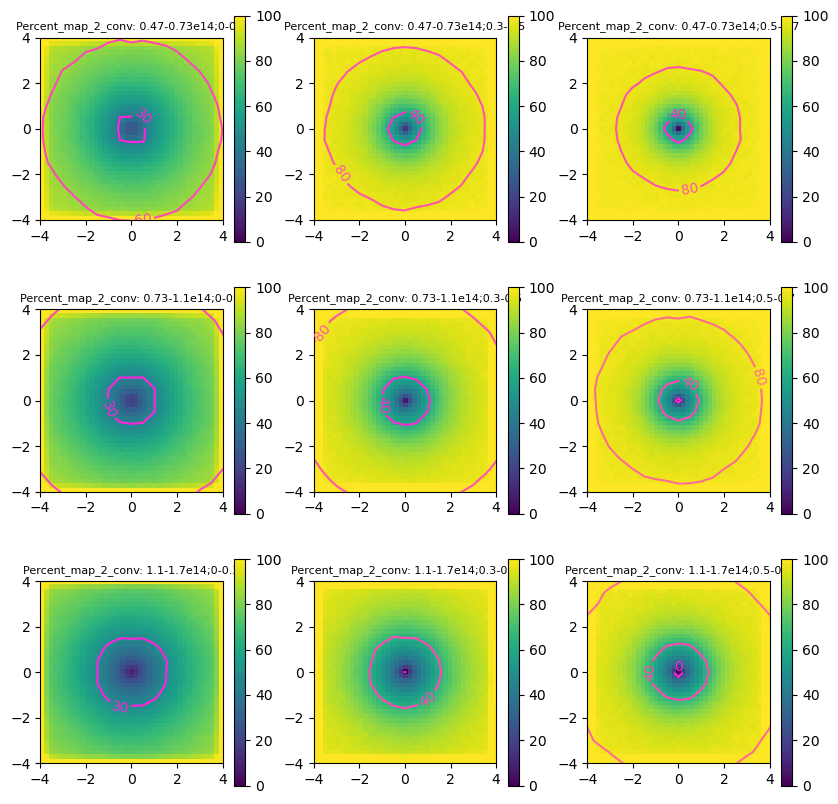

In [96]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
extent= [-4,4,-4,4]
fsize = 8
vmin, vmax = (0, 100)
im11 = axes[0,0].imshow(map_11, vmin=vmin, vmax=vmax) 
axes[0,0].set_title(str_11, fontsize=fsize)
CS = axes[0,0].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_11, levels=5, cmap="spring")
im11.set_extent(extent)
plt.clabel(CS)
im12 = axes[0,1].imshow(map_12, vmin=vmin, vmax=vmax) 
axes[0,1].set_title(str_12, fontsize=fsize)
CS = axes[0,1].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_12, levels=5, cmap="spring")
im12.set_extent(extent)
plt.clabel(CS)
im13 = axes[0,2].imshow(map_13, vmin=vmin, vmax=vmax) 
axes[0,2].set_title(str_13, fontsize=fsize)
CS = axes[0,2].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_13, levels=5, cmap="spring")
im13.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im11)
plt.colorbar(im12)
plt.colorbar(im13)

im21 = axes[1,0].imshow(map_21, vmin=vmin, vmax=vmax) 
axes[1,0].set_title(str_21, fontsize=fsize)
CS = axes[1,0].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_21, levels=5, cmap="spring")
im21.set_extent(extent)
plt.clabel(CS)
im22 = axes[1,1].imshow(map_22, vmin=vmin, vmax=vmax) 
axes[1,1].set_title(str_22, fontsize=fsize)
CS = axes[1,1].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_22, levels=5, cmap="spring")
im22.set_extent(extent)
plt.clabel(CS)
im23 = axes[1,2].imshow(map_23, vmin=vmin, vmax=vmax) 
axes[1,2].set_title(str_23, fontsize=fsize)
CS = axes[1,2].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_23, levels=5, cmap="spring")
im23.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im21)
plt.colorbar(im22)
plt.colorbar(im23)

im31 = axes[2,0].imshow(map_31, vmin=vmin, vmax=vmax) 
axes[2,0].set_title(str_31, fontsize=fsize)
CS = axes[2,0].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_31, levels=5, cmap="spring")
im31.set_extent(extent)
plt.clabel(CS)
im32 = axes[2,1].imshow(map_32, vmin=vmin, vmax=vmax) 
axes[2,1].set_title(str_32, fontsize=fsize)
CS = axes[2,1].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_32, levels=5, cmap="spring")
im32.set_extent(extent)
plt.clabel(CS)
im33 = axes[2,2].imshow(map_33, vmin=vmin, vmax=vmax) 
axes[2,2].set_title(str_33, fontsize=fsize)
CS = axes[2,2].contour(np.arange(-10,10+0.5,0.5),np.arange(-10,10+0.5,0.5), map_33, levels=5, cmap="spring")
im33.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im31)
plt.colorbar(im32)
plt.colorbar(im33)



NameError: name 'CS' is not defined

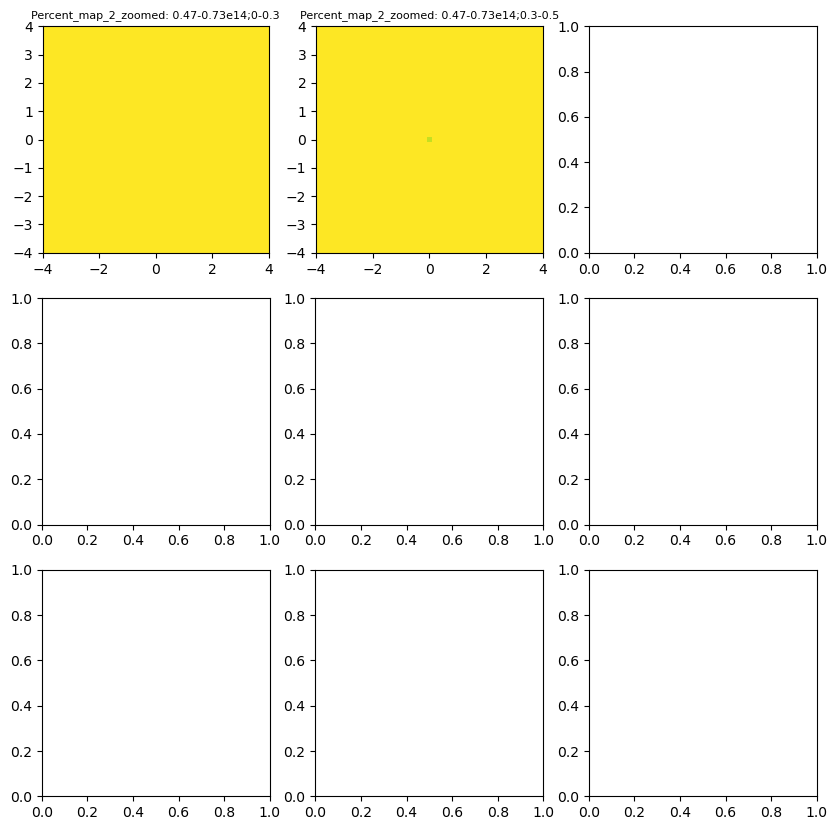

In [75]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
extent= [-4,4,-4,4]
fsize = 8
vmin, vmax = (-10, 15)
im11 = axes[0,0].imshow(map_11, vmin=vmin, vmax=vmax) 
axes[0,0].set_title(str_11, fontsize=fsize)
im11.set_extent(extent)
im12 = axes[0,1].imshow(map_12, vmin=vmin, vmax=vmax) 
axes[0,1].set_title(str_12, fontsize=fsize)
im12.set_extent(extent)
plt.clabel(CS)
im13 = axes[0,2].imshow(map_13, vmin=vmin, vmax=vmax) 
axes[0,2].set_title(str_13, fontsize=fsize)
im13.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im11)
plt.colorbar(im12)
plt.colorbar(im13)

im21 = axes[1,0].imshow(map_21, vmin=vmin, vmax=vmax) 
axes[1,0].set_title(str_21, fontsize=fsize)
im21.set_extent(extent)
plt.clabel(CS)
im22 = axes[1,1].imshow(map_22, vmin=vmin, vmax=vmax) 
axes[1,1].set_title(str_22, fontsize=fsize)
im22.set_extent(extent)
plt.clabel(CS)
im23 = axes[1,2].imshow(map_23, vmin=vmin, vmax=vmax) 
axes[1,2].set_title(str_23, fontsize=fsize)
im23.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im21)
plt.colorbar(im22)
plt.colorbar(im23)

im31 = axes[2,0].imshow(map_31, vmin=vmin, vmax=vmax) 
axes[2,0].set_title(str_31, fontsize=fsize)
im31.set_extent(extent)
plt.clabel(CS)
im32 = axes[2,1].imshow(map_32, vmin=vmin, vmax=vmax) 
axes[2,1].set_title(str_32, fontsize=fsize)
im32.set_extent(extent)
plt.clabel(CS)
im33 = axes[2,2].imshow(map_33, vmin=vmin, vmax=vmax) 
axes[2,2].set_title(str_33, fontsize=fsize)
im33.set_extent(extent)
plt.clabel(CS)
plt.colorbar(im31)
plt.colorbar(im32)
plt.colorbar(im33)

In [132]:
print(map_1.max(), map_2.max(), map_3.max(), map_4.max())
print(map_1.min(), map_2.min(), map_3.min(), map_4.min())

6.227994067482658 6.785652072748288 8.243860140356837 11.063582827037388
2.4260770094366024 2.134731775760112 0.7359114574443041 -2.1552252026264163


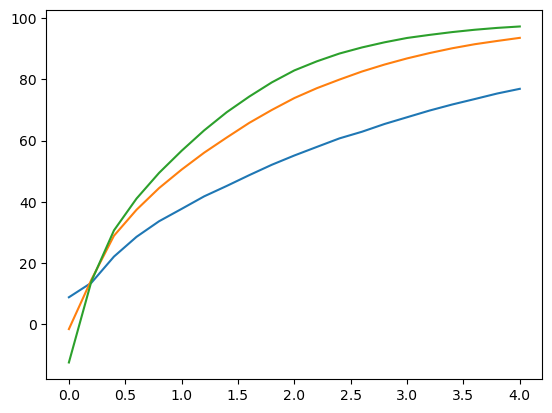

In [87]:
X = np.arange(0,4.2,0.2)
plt.plot(X, map_31[20,20:])
plt.plot(X, map_32[20,20:])
plt.plot(X, map_33[20,20:])

In [88]:
onesvec = np.ones(41)
inds = np.arange(-4,4.2,0.2)
X = np.outer(onesvec,inds)
Y = X.transpose()
R = np.sqrt(X**2 + Y**2)
R.max()

5.65685424949239

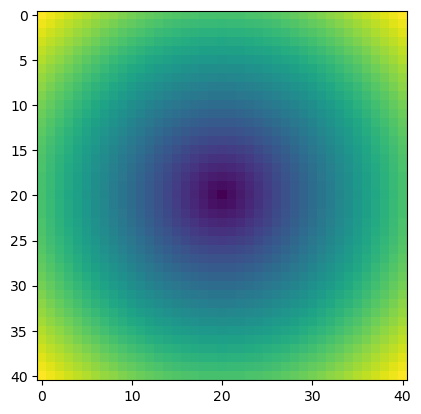

In [89]:
plt.imshow(R)

In [106]:
radii = np.unique(R)
profile = np.zeros(radii.shape)
nums = np.zeros(radii.shape)
map_to_avg = map_11
for i in range(41):
    for j in range(41):
        profile[radii==R[i,j]] += map_to_avg[i,j]
        nums[radii==R[i,j]] += 1
profile = profile /nums 

Text(0.5, 1.0, 'Percent Difference Profiles, All calculated on 0 < z < 0.3')

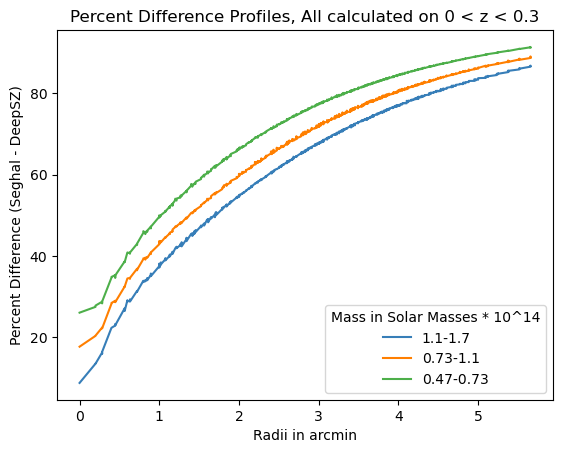

In [93]:
#profile_47_73_0_3 = profile
plt.plot(radii, profile_11_17_0_3, '#377eb8', label="1.1-1.7")
plt.plot(radii, profile_73_11_0_3, '#ff7f00', label="0.73-1.1")
plt.plot(radii, profile_47_73_0_3, '#4daf4a', label="0.47-0.73")
legend = plt.legend()
legend.set_title("Mass in Solar Masses * 10^14")
plt.xlabel("Radii in arcmin")
plt.ylabel("Percent Difference (Seghal - DeepSZ)")
plt.title("Percent Difference Profiles, All calculated on 0 < z < 0.3")

Text(0.5, 1.0, 'Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14')

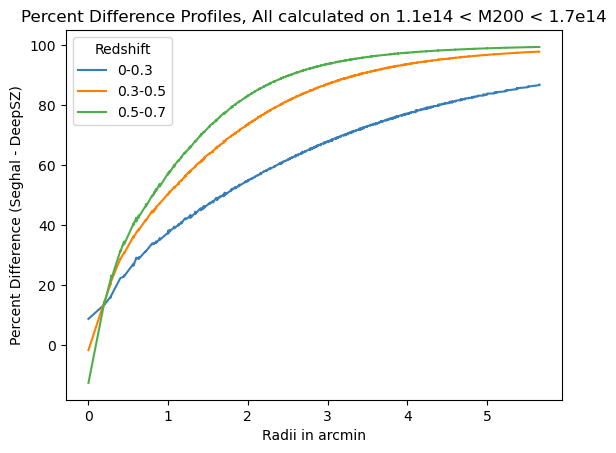

In [94]:
#profile_11_17_5_7 = profile
plt.plot(radii, profile_11_17_0_3, '#377eb8', label="0-0.3")
plt.plot(radii, profile_11_17_3_5, '#ff7f00', label="0.3-0.5")
plt.plot(radii, profile_11_17_5_7, '#4daf4a', label="0.5-0.7")
legend = plt.legend()
legend.set_title("Redshift")
plt.xlabel("Radii in arcmin")
plt.ylabel("Percent Difference (Seghal - DeepSZ)")
plt.title("Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14")

Text(0.5, 1.0, 'Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14 \n (With Beam Convolution)')

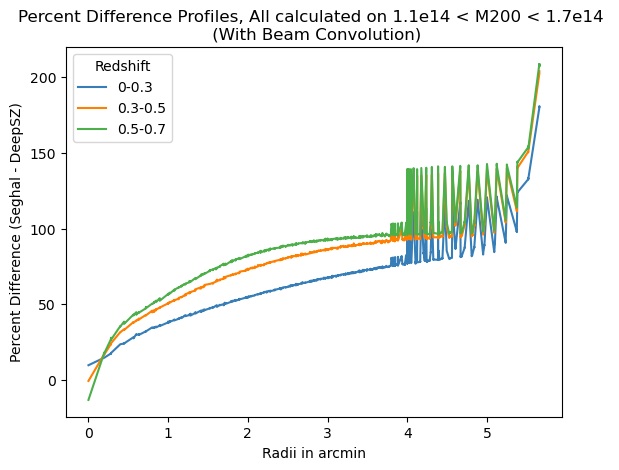

In [103]:
#profile_11_17_0_3c = profile
plt.plot(radii, profile_11_17_0_3c, '#377eb8', label="0-0.3")
plt.plot(radii, profile_11_17_3_5c, '#ff7f00', label="0.3-0.5")
plt.plot(radii, profile_11_17_5_7c, '#4daf4a', label="0.5-0.7")
legend = plt.legend()
legend.set_title("Redshift")
plt.xlabel("Radii in arcmin")
plt.ylabel("Percent Difference (Seghal - DeepSZ)")
plt.title("Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14 \n (With Beam Convolution)")

Text(0.5, 1.0, 'Percent Difference Profiles, All calculated on 0 < z < 0.3 \n (With Beam Convolution)')

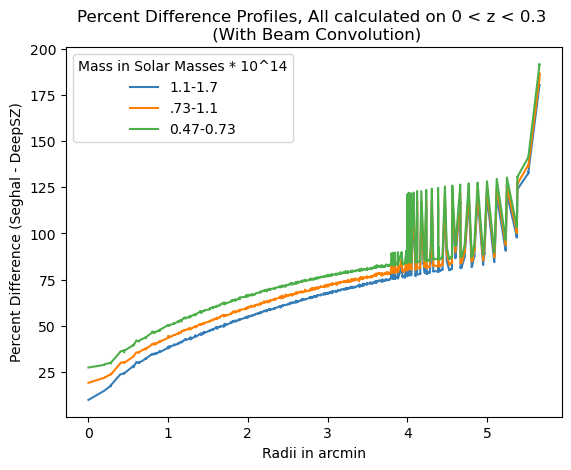

In [108]:
#profile_47_73_0_3c = profile
plt.plot(radii, profile_11_17_0_3c, '#377eb8', label="1.1-1.7")
plt.plot(radii, profile_73_11_0_3c, '#ff7f00', label=".73-1.1")
plt.plot(radii, profile_47_73_0_3c, '#4daf4a', label="0.47-0.73")
legend = plt.legend()
legend.set_title("Mass in Solar Masses * 10^14")
plt.xlabel("Radii in arcmin")
plt.ylabel("Percent Difference (Seghal - DeepSZ)")
plt.title("Percent Difference Profiles, All calculated on 0 < z < 0.3 \n (With Beam Convolution)")

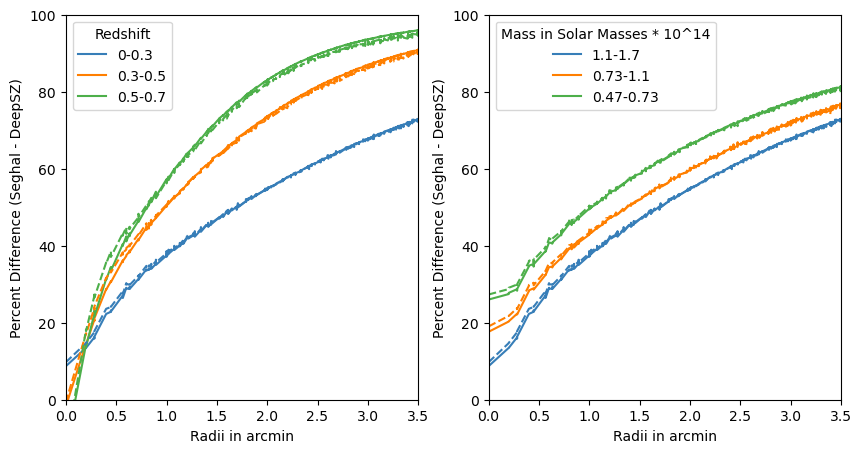

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

ax = axes[0]
ax.plot(radii, profile_11_17_0_3, '#377eb8', label="0-0.3")
ax.plot(radii, profile_11_17_3_5, '#ff7f00', label="0.3-0.5")
ax.plot(radii, profile_11_17_5_7, '#4daf4a', label="0.5-0.7")
legend = ax.legend()
legend.set_title("Redshift")
ax.set_xlabel("Radii in arcmin")
ax.set_ylabel("Percent Difference (Seghal - DeepSZ)")
ax.set_xlim(0,3.5)
ax.set_ylim(0,100)
#plt.title("Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14")

ax = axes[1]
ax.plot(radii, profile_11_17_0_3, '#377eb8', label="1.1-1.7")
ax.plot(radii, profile_73_11_0_3, '#ff7f00', label="0.73-1.1")
ax.plot(radii, profile_47_73_0_3, '#4daf4a', label="0.47-0.73")
legend = ax.legend()
legend.set_title("Mass in Solar Masses * 10^14")
ax.set_xlabel("Radii in arcmin")
ax.set_ylabel("Percent Difference (Seghal - DeepSZ)")
ax.set_xlim(0,3.5)
ax.set_ylim(0,100)
#plt.title("Percent Difference Profiles, All calculated on 0 < z < 0.3")

ax = axes[0]
ax.plot(radii, profile_11_17_0_3c, '#377eb8', linestyle='dashed', label="0-0.3")
ax.plot(radii, profile_11_17_3_5c, '#ff7f00', linestyle='dashed', label="0.3-0.5")
ax.plot(radii, profile_11_17_5_7c, '#4daf4a', linestyle='dashed', label="0.5-0.7")
#legend = ax.legend()
#legend.set_title("Redshift")
#ax.set_xlabel("Radii in arcmin")
#ax.set_ylabel("Percent Difference (Seghal - DeepSZ)")
#ax.set_xlim(0,3.5)
#ax.set_ylim(0,100)
#ax.set_title("Percent Difference Profiles, All calculated on 1.1e14 < M200 < 1.7e14 \n (With Beam Convolution)")

ax = axes[1]
ax.plot(radii, profile_11_17_0_3c, '#377eb8', linestyle='dashed', label="1.1-1.7")
ax.plot(radii, profile_73_11_0_3c, '#ff7f00', linestyle='dashed', label=".73-1.1")
ax.plot(radii, profile_47_73_0_3c, '#4daf4a', linestyle='dashed', label="0.47-0.73")
#legend = ax.legend()
#legend.set_title("Mass in Solar Masses * 10^14")
# ax.set_xlabel("Radii in arcmin")
# ax.set_ylabel("Percent Difference (Seghal - DeepSZ)")
# ax.set_xlim(0,3.5)
# ax.set_ylim(0,100)
#ax.title("Percent Difference Profiles, All calculated on 0 < z < 0.3 \n (With Beam Convolution)")